In this notebook I apply some common clustering and dimensionality reduction tools to historical monthly pressure data series measured at 93 stations in and around Europe (data reference: https://doi.org/10.1007/s00382-009-0577-9).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.decomposition import PCA
%matplotlib inline

I start by reading in the data and dropping the measurements before the year 1880 and after 2000 to reduce the number of missing values:

In [2]:
PP = pd.read_csv("../data/Stations_PP_1722_monthly_final_po_corrected.csv", sep="\t")
PP = PP[(PP.Jahr>=1880)&(PP.Jahr<=2000)]
PP.head()

,Jahr,Monat,PP_PARIS,PP_BASEL,PP_GENEVA,PP_Neuchatel,PP_Saentis,PP_Lugano,PP_GrStBernard,PP_TRONDHEIM,...,PP_SPLIT,PP_SULINA,PP_GE11A,PP_STYKKISHOLM,PP_Zagreb,PP_Karlsruhe,PP_Po_Plain,PP_Boothville_New_Orleans,PP_CasaBlanca_Cuba_Miami,PP_Lockbourne_Columbus
1561,1880,1,1030.4,9904.0,9790.0,9694.0,NaN,9932.0,7533.0,1015.4,...,1026.6,1025.5,1024.95,1002.8,1028.2,10111.0,1028.59,1019.1,1016.3,1019.0
1562,1880,2,1015.5,9793.0,9689.0,9595.0,NaN,9851.0,7484.0,1002.4,...,1019.0,1025.0,1016.23,993.3,1020.0,9982.0,1018.47,1020.2,1018.4,1018.0
1563,1880,3,1021.1,9831.0,9715.0,9626.0,NaN,9881.0,7530.0,1019.0,...,1021.9,1021.3,1020.43,1006.8,1022.3,10031.0,1021.51,1017.0,1017.2,1018.0
1564,1880,4,1013.4,9749.0,9637.0,9547.0,NaN,9800.0,7469.0,1012.2,...,1013.9,1016.9,1011.41,1004.2,1012.5,9948.0,1012.00,1017.0,1017.9,1015.0
1565,1880,5,1018.1,9782.0,9660.0,9576.0,NaN,9802.0,7498.0,1015.1,...,1012.5,1014.9,1011.46,1013.1,1013.7,9985.0,1011.95,1014.1,1013.7,1016.0


I then drop any station with missing values as well as North American stations and the columns for year and month:

In [3]:
PP = PP.iloc[:,:100]
PP.drop('PP_DeMoines_USA', axis=1, inplace=True)
PP.dropna(axis=1, inplace=True)
X = PP.iloc[:,2:]
X.shape

(1452, 93)

I am left with 93 complete time series, each 1452 months (i.e., 121 years) long. Since units are not the same,  I also need to rescale the data, using a standard scaling:

In [4]:
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X.describe()

,PP_PARIS,PP_BASEL,PP_GENEVA,PP_Neuchatel,PP_Lugano,PP_GrStBernard,PP_TRONDHEIM,PP_EDINBURGH,PP_LONDON,PP_VIENNA,...,PP_UPERNAVIK,PP_AKUREYRI,PP_LA_CORUNA,PP_SPLIT,PP_SULINA,PP_GE11A,PP_STYKKISHOLM,PP_Zagreb,PP_Karlsruhe,PP_Po_Plain
count,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,...,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03,1.452000e+03
mean,2.654381e-14,3.768030e-15,1.902610e-14,-2.269626e-14,2.085140e-14,6.185441e-15,-2.785406e-14,-1.104718e-14,2.055534e-14,-3.168570e-15,...,-5.020777e-15,-1.502318e-15,-5.999486e-15,-1.288470e-14,2.669429e-14,-1.726687e-14,1.358815e-14,1.756905e-14,3.983346e-15,-1.945918e-14
std,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,...,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00,1.000345e+00
min,-3.623851e+00,-3.219164e+00,-3.254301e+00,-3.236781e+00,-3.223715e+00,-3.309338e+00,-3.881542e+00,-3.518866e+00,-3.463919e+00,-2.871583e+00,...,-3.048633e+00,-3.729666e+00,-3.457318e+00,-3.304086e+00,-2.217933e+00,-3.366145e+00,-4.006366e+00,-2.973207e+00,-3.186788e+00,-2.576469e+00
25%,-6.245867e-01,-5.990385e-01,-5.985499e-01,-6.193067e-01,-6.054597e-01,-7.458980e-01,-6.445855e-01,-5.991228e-01,-5.943815e-01,-6.482682e-01,...,-6.648528e-01,-5.931775e-01,-5.416711e-01,-6.500134e-01,-7.381249e-01,-5.870941e-01,-5.786266e-01,-6.581753e-01,-6.070309e-01,-6.469604e-01
50%,-6.417580e-03,-2.376215e-03,1.227279e-02,3.506190e-02,-5.424803e-02,9.610772e-02,9.262721e-02,8.385801e-02,4.686927e-03,-1.181864e-01,...,1.437326e-02,1.407943e-01,-3.805931e-02,-1.191989e-01,-1.487098e-01,-7.418653e-02,1.164146e-01,-1.308627e-01,-1.170225e-02,-1.719561e-01
75%,5.430660e-01,5.683443e-01,5.965380e-01,5.912752e-01,5.520848e-01,8.445572e-01,6.603657e-01,6.814662e-01,6.237243e-01,5.165234e-01,...,6.373577e-01,6.818804e-01,4.920584e-01,5.677376e-01,6.664388e-01,4.868491e-01,7.131329e-01,5.250628e-01,5.836264e-01,5.032150e-01
max,3.588121e+00,3.862958e+00,3.809996e+00,3.778050e+00,3.969597e+00,1.967232e+00,2.948267e+00,3.635358e+00,3.599098e+00,4.241863e+00,...,3.821500e+00,2.831800e+00,3.460717e+00,4.220990e+00,3.550811e+00,4.557107e+00,2.788085e+00,4.409171e+00,3.882739e+00,4.175243e+00


Since these are monthly averages, they should be close to normality. A quick check on skewness reveals no particularly concerning features:

Text(0.5, 0, 'Skewness')

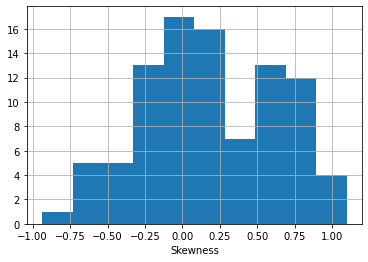

In [5]:
ax = X.skew().hist()
ax.set_xlabel("Skewness")

### K-Means

I want to find the ideal number of clusters using K-Means and the elbow method.

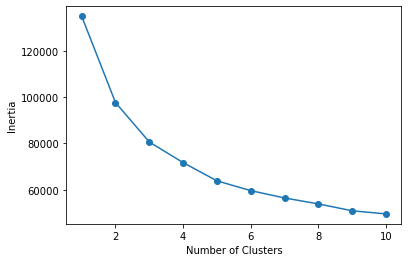

In [6]:
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=64, n_init=1)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

The choice is not obvious but I will use 4 clusters. I now plot on a map the centroid of each cluster:

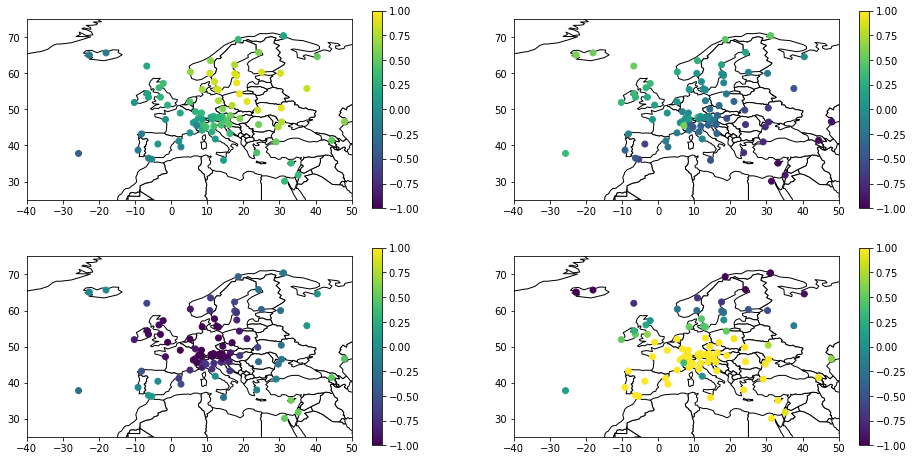

In [7]:
km = KMeans(n_clusters=4, random_state=64, n_init=1)
km.fit(X)
coords = pd.read_csv("../data/Stations_PP_1722_coordinates.csv", sep="\t")
coords = coords[coords.Stationsname.isin(X.columns)]
gdf = geopandas.GeoDataFrame(coords, 
                             geometry=geopandas.points_from_xy(coords['Longitude.E.'],coords['Latitude.N.']))
eu = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
fig, axes = plt.subplots(2, 2, figsize=[16,8])
pos = [(0,0),(0,1),(1,0),(1,1)]
for lab in range(4):
    ax = axes[pos[lab]]
    eu.plot(ax=ax, color='white', edgecolor='black')
    ax.set_xlim(-40, 50)
    ax.set_ylim(25, 75)
    gdf.plot(ax=ax, column=km.cluster_centers_[lab,:], cmap='viridis', legend=True, vmin=-1, vmax=1)
plt.show()

Two of the clusters have a clear north-south pattern and can be related to the two phases of the North Atlantic Oscillation (NAO: https://en.wikipedia.org/wiki/North_Atlantic_oscillation). The first cluster can be interpreted as the Scandinavian pattern (https://www.cpc.ncep.noaa.gov/data/teledoc/scand_map.shtml).

### Mean Shift
Here I apply Mean Shift clustering using a banwidth that results in 4 clusters, and again I plot the centroids on a map:

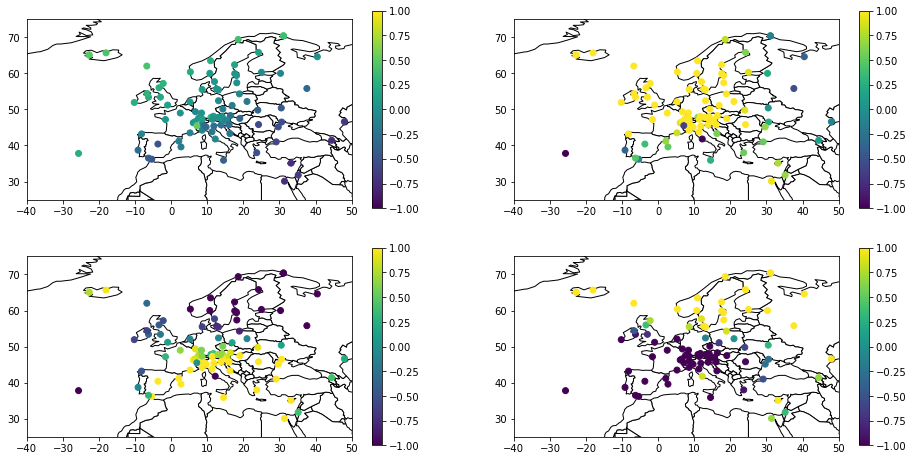

In [8]:
ms = MeanShift(bandwidth=8.1, n_jobs=-1)
ms.fit(X)
fig, axes = plt.subplots(2, 2, figsize=[16,8])
pos = [(0,0),(0,1),(1,0),(1,1)]
for lab in range(4):
    ax = axes[pos[lab]]
    eu.plot(ax=ax, color='white', edgecolor='black')
    ax.set_xlim(-40, 50)
    ax.set_ylim(25, 75)
    gdf.plot(ax=ax, column=ms.cluster_centers_[lab,:], cmap='viridis', legend=True, vmin=-1, vmax=1)
plt.show()

The results are a bit less meaningful than for K-Means, but they highlight better some problematic stations: in particular Rome has clearly wrong data (perhaps shifted in time).

### Principal Component Analysis
Given that many stations are geographically very close to each other and, therefore, their pressure series are highly correlated, it makes sense to apply dimensionality reduction through PCA. The expectation is that just one principal component will explain a large fraction of variance (in fact, this is how the NAO is often defined).

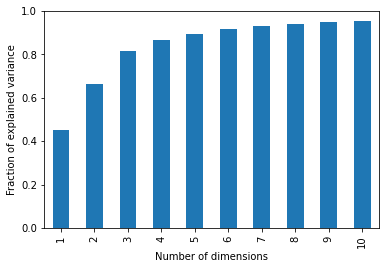

In [9]:
PCAmod = PCA(n_components=10)
PCAmod.fit(X)
ax = pd.Series(PCAmod.explained_variance_ratio_).cumsum().plot(kind='bar')
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax.set(xlabel='Number of dimensions', ylabel='Fraction of explained variance');

The first component explains indeed 45% of the variance, and 5 components are sufficient to explain over 90%. Let us plot the 4 main components on a map:

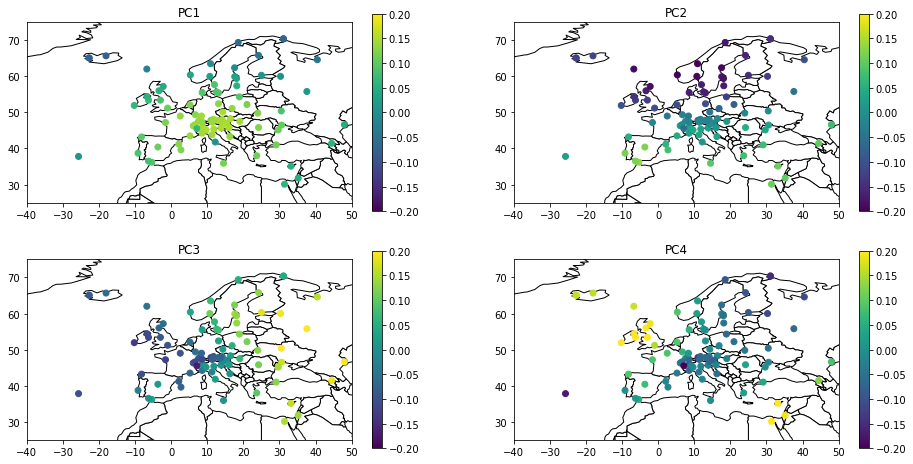

In [10]:
fig, axes = plt.subplots(2, 2, figsize=[16,8])
pos = [(0,0),(0,1),(1,0),(1,1)]
for lab in range(4):
    ax = axes[pos[lab]]
    eu.plot(ax=ax, color='white', edgecolor='black')
    ax.set_xlim(-40, 50)
    ax.set_ylim(25, 75)
    ax.set_title('PC' + str(lab+1))
    gdf.plot(ax=ax, column=PCAmod.components_[lab,:], cmap='viridis', legend=True, vmin=-0.2, vmax=0.2) 
plt.show()